<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap11_3_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capítulo 11 - Redes Neurais Convolucionais

## 11.3 - Transferência de Aprendizado

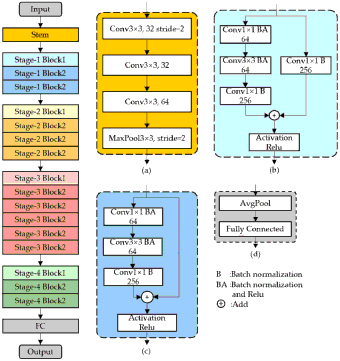

Informações sobre a coleção de imagens utilizada. É uma amostragem aleatória do conjunto

In [1]:
!pip install -U keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.3 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires keras<2.9,>=2.8.0rc0, but you have keras 2.9.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.9 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0


### Leitura das imagens

Fazer o carregamento de coleções de imagens que estão já carregadas dentro do Keras-tensorflow é tranquilo, vide o [Cifar-10 (recomendo ver este link)](https://keras.io/api/datasets/cifar10/). E quando temos e queremos processar nossas próprias imagens? Aí é um pouco mais difícil, mas não impossível!

Para viabilizar o carregamento das imagens em uma estrutura que permita ler as imagens do disco e processá-las pelos objetos do Keras-tensorflow, vamos utilizar a classe [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Os principais motivos dessa escolha são:

*   Facilidade de se carregar imagens diretamente do disco ou por DataFrames;
*   Facilidade de utilizar operações de pré-processamento (normalização, reescalonamento etc) e que podem ser úteis em uma etapa conhecida como DataAugmentation (veremos adiante)!

### Organizando os arquivos das imagens

A pasta principal da coleção de imagens possui nome "documents". Dentro dessa pasta existem três subpastas, cada uma associada com uma label:

*   documents
    + advertisement
    + email
    + scientific paper

Nesse notebook, teremos que dividir a coleção de imagens em sub-partes (treinamento, validação e testes) utilizando a técnica Holdout. Essa técnica foi escolhida pela sua simplicidade e para facilitar a codificação na sala de aula. Entretanto, recomenda-se o uso da técnica [Stratified K-Fold Cross Validation](lectures/cap08_2_avaliacao_desempenho.ipynb) para avaliação do desempenho da classificação, visto que essa abordagem retorna resultados menos enviesados em relação à amostragem realizada para obter a divisão treinamento-validação-teste e que evita risco de supertreinamento *overfitting*.

Supondo que a pasta "documents" esteja no Google Drive, vamos montar o drive e copiar a pasta para o ambiente no Colab:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r '/content/drive/MyDrive/ocr/full_3/' 'documents'

Fazendo-se os imports necessários:

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Leitura de dados

In [5]:
path_documents = 'documents'
lista_subfolders = os.listdir(path_documents)

dataset_dict = {}

dataset_dict['filename'] = []
dataset_dict['label'] = []

for folder in lista_subfolders:
    lista_imagens = os.listdir(path_documents+'/'+folder)

    for img_file in lista_imagens:
        dataset_dict['filename'].append(folder+'/'+img_file)
        dataset_dict['label'].append(folder)

In [6]:
df = pd.DataFrame(dataset_dict,columns=['filename','label'])

In [7]:
X = df['filename'].values
y = df['label'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=45)

Criação dos logits dos labels

In [9]:
from keras.utils.np_utils import to_categorical

train_labels = pd.Categorical(y_train)
valid_labels = pd.Categorical(y_valid)
test_labels = pd.Categorical(y_test)

y_train_int = train_labels.codes
y_valid_int = valid_labels.codes
y_test_int = test_labels.codes

y_train_logits = to_categorical(y_train_int)
y_valid_logits = to_categorical(y_valid_int)
y_test_logits = to_categorical(y_test_int)

In [10]:
lista_train = []
for i in range(0,len(X_train)):
    lista_train.append([X_train[i],y_train[i]])

lista_valid = []
for i in range(0,len(X_valid)):
    lista_valid.append([X_valid[i],y_valid[i]])

lista_test = []
for i in range(0,len(X_test)):
    lista_test.append([X_test[i],y_test[i]])

In [11]:
df_train = pd.DataFrame(lista_train,columns = ['filename','label'])
df_valid = pd.DataFrame(lista_valid,columns = ['filename','label'])
df_test = pd.DataFrame(lista_test,columns = ['filename','label'])

In [12]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(df_train,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = datagen.flow_from_dataframe(df_valid,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

test_generator = datagen.flow_from_dataframe(df_test,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                             class_mode='categorical',
                                              shuffle=True)


Found 2072 validated image filenames belonging to 3 classes.
Found 355 validated image filenames belonging to 3 classes.
Found 534 validated image filenames belonging to 3 classes.


Hyperparameters

In [13]:
dims = (224,224,3)
num_classes = 3

In [14]:
model_resnet_pt = Sequential()

pre_trained_model = ResNet50(input_shape=(224,224,3),
    include_top=False,
    pooling ='avg',
    weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False

model_resnet_pt.add(pre_trained_model)
model_resnet_pt.add(Flatten())

model_resnet_pt.add(Dense(num_classes))
model_resnet_pt.add(Activation("softmax"))

94781440/94765736 [==============================] - 0s 0us/step


In [15]:
model_resnet_pt.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
sgd = SGD(learning_rate=0.0001)

model_resnet_pt.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

history_fine =model_resnet_pt.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=valid_generator)

Epoch 1/30
65/65 [==============================] - 29s 233ms/step - loss: 1.0900 - accuracy: 0.4566 - val_loss: 1.0384 - val_accuracy: 0.5437
Epoch 2/30
65/65 [==============================] - 13s 191ms/step - loss: 1.0226 - accuracy: 0.5980 - val_loss: 1.0204 - val_accuracy: 0.5549
Epoch 3/30
65/65 [==============================] - 12s 181ms/step - loss: 1.0054 - accuracy: 0.5912 - val_loss: 1.0043 - val_accuracy: 0.5803
Epoch 4/30
65/65 [==============================] - 14s 218ms/step - loss: 0.9886 - accuracy: 0.6028 - val_loss: 0.9897 - val_accuracy: 0.6000
Epoch 5/30
65/65 [==============================] - 12s 185ms/step - loss: 0.9735 - accuracy: 0.6158 - val_loss: 0.9761 - val_accuracy: 0.6000
Epoch 6/30
65/65 [==============================] - 12s 178ms/step - loss: 0.9587 - accuracy: 0.6240 - val_loss: 0.9628 - val_accuracy: 0.6000
Epoch 7/30
65/65 [==============================] - 12s 184ms/step - loss: 0.9446 - accuracy: 0.6588 - val_loss: 0.9519 - val_accuracy: 0.5915

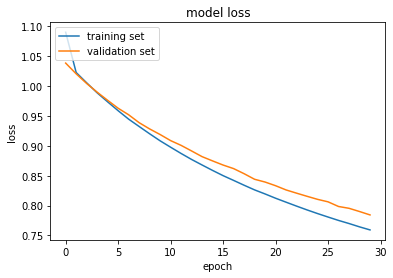

In [17]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

Provavelmente temos um underfitting... tentando de novo

In [18]:
y_prob = model_resnet_pt.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

y_test = test_generator.classes
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.32      0.27      0.29       176
           1       0.35      0.39      0.37       193
           2       0.26      0.27      0.27       165

    accuracy                           0.31       534
   macro avg       0.31      0.31      0.31       534
weighted avg       0.31      0.31      0.31       534



In [19]:
model_resnet_pt = Sequential()

pre_trained_model = ResNet50(input_shape=(224,224,3),
    include_top=False,
    pooling ='avg',
    weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False

model_resnet_pt.add(pre_trained_model)
model_resnet_pt.add(Flatten())

model_resnet_pt.add(Dense(512))
model_resnet_pt.add(Activation("relu"))
model_resnet_pt.add(Dropout(0.5))

model_resnet_pt.add(Dense(num_classes))
model_resnet_pt.add(Activation("softmax"))

In [20]:
sgd = SGD(learning_rate=0.00002)

model_resnet_pt.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

history_fine =model_resnet_pt.fit(train_generator,
                        epochs=10,
                        batch_size=32,
                        validation_data=valid_generator)

Epoch 1/10
65/65 [==============================] - 18s 211ms/step - loss: 1.8456 - accuracy: 0.3388 - val_loss: 1.5709 - val_accuracy: 0.2873
Epoch 2/10
65/65 [==============================] - 13s 201ms/step - loss: 1.5458 - accuracy: 0.3586 - val_loss: 1.3249 - val_accuracy: 0.2930
Epoch 3/10
65/65 [==============================] - 12s 190ms/step - loss: 1.4168 - accuracy: 0.3605 - val_loss: 1.1900 - val_accuracy: 0.3437
Epoch 4/10
65/65 [==============================] - 12s 180ms/step - loss: 1.3519 - accuracy: 0.3567 - val_loss: 1.1144 - val_accuracy: 0.4197
Epoch 5/10
65/65 [==============================] - 12s 176ms/step - loss: 1.2958 - accuracy: 0.3774 - val_loss: 1.0665 - val_accuracy: 0.4873
Epoch 6/10
65/65 [==============================] - 12s 177ms/step - loss: 1.2423 - accuracy: 0.3929 - val_loss: 1.0402 - val_accuracy: 0.5239
Epoch 7/10
65/65 [==============================] - 12s 180ms/step - loss: 1.2698 - accuracy: 0.3610 - val_loss: 1.0206 - val_accuracy: 0.5521

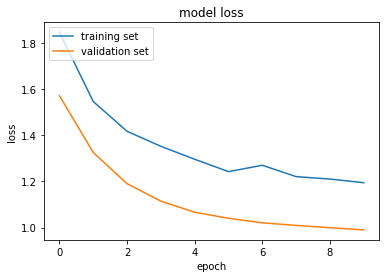

In [21]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

Avaliação de performance com os dados de teste

In [22]:
y_prob = model_resnet_pt.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.39      0.36      0.37       176
           1       0.36      0.64      0.47       193
           2       0.24      0.05      0.08       165

    accuracy                           0.37       534
   macro avg       0.33      0.35      0.31       534
weighted avg       0.34      0.37      0.32       534

